In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/hcp/Handedness/handedness_labels.csv"
embeddings_subpath = "hcp_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isRightHanded_hcp_without_residualization.csv"
label = "isRightHanded"
max_iter = 2000
cv = 3

In [3]:
participants = pd.read_csv(participants_file, index_col=0)


In [4]:
participants[:] = participants.sample(frac=1).values

In [5]:
participants = participants[["isRightHanded"]]

In [6]:
participants = participants[[label]].dropna()

array([[<Axes: title={'center': 'isRightHanded'}>]], dtype=object)

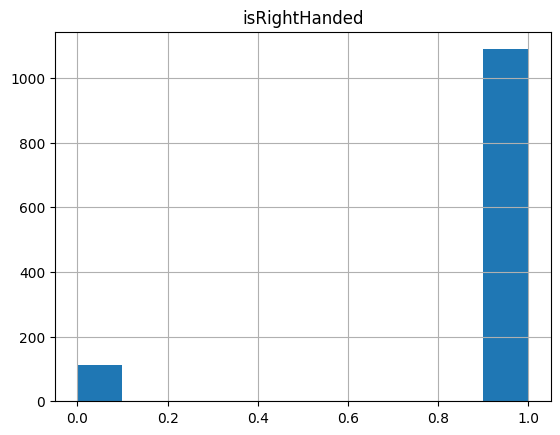

In [7]:
participants.hist()

In [8]:
print(len(participants[participants.isRightHanded==0]))
print(len(participants[participants.isRightHanded==1]))

113
1089


In [9]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [10]:
model_paths = get_model_paths(path_champollion)

In [11]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [12]:
def compute(model_path):
    global embeddings
    global participants
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label, "folds"]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop([label, "folds"], axis=1)
    Y = merged[label]
    groups = merged["folds"]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1, class_weight='balanced')
    logo = LeaveOneGroupOut()
    cv = logo.split(X, Y, groups)
    res = cross_val_score(model, X, Y, cv=cv, scoring='balanced_accuracy')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [13]:
def iterative_split_through_sorting_shuffle(df, n_splits, stratify_columns, random_state):
    """Custom iterative train test split which
    maintains balanced representation.
    """
    # Dataframe random row shuffle + sorting according to stratify_columns
    sorted = df.sample(frac=1, random_state=random_state).sort_values(stratify_columns)
    # for each fold, we take one row every n_splits rows
    folds = [sorted.iloc[i::n_splits, :] for i in range(n_splits)]
    # Further shuffling
    folds = [fold.sample(frac=1, random_state=random_state) for fold in folds]
    random.Random(random_state).shuffle(folds)
    return folds

In [14]:
def print_results(parent, folds, col, verbose=True):

    # For each conbination of labels, prints the number of rows for each fold
    # having this combination
    total_errors = 0
    n_splits = len(folds)
    if verbose:
        print("query   : #rows      : #rows per fold\n")

    for col0 in parent[col[0]].unique():
        df = parent.query(f"{col[0]}==@col0")
        len_query = len(df)
        if verbose:
            print(f"{col0}: total = {len_query} : per fold =", end = ' ')
        for fold in folds:
            df0 = fold.query(f"{col[0]}==@col0")
            len_query_fold = len(df0)
            if abs(len_query_fold-len_query/n_splits) >= 2:
                total_errors += 1
            if verbose:
                print(f"{len_query_fold} -", end= ' ')
        if verbose:
            print("")

    # Prints the statistics and the number of stratification errors
    expected_total_length = len(parent)
    total_length = 0
    total_mismatches = 0
    print("\nlengths of folds : ", end = ' ')
    for fold in folds:
        len_fold = len(fold)
        print(len_fold, end=' ')
        total_length += len_fold
        if abs(len_fold-expected_total_length/n_splits) >= 2:
            total_mismatches += 1
    print(f"\nExpected total_length = {expected_total_length}")
    print(f"Effective total_length = {total_length}")

    print(f"total number of stratification errors: {total_errors}")
    print(f"total number of mismatched fold sizes : {total_mismatches}")

In [15]:
participants.dtypes

isRightHanded    float64
dtype: object

In [16]:
folds = iterative_split_through_sorting_shuffle(participants, cv, ["isRightHanded"], 1)

In [17]:
folds[0].dtypes

isRightHanded    float64
dtype: object

In [18]:
print_results(participants, folds, ["isRightHanded"])

query   : #rows      : #rows per fold

1.0: total = 1089 : per fold = 363 - 363 - 363 - 
0.0: total = 113 : per fold = 38 - 37 - 38 - 

lengths of folds :  401 400 401 
Expected total_length = 1202
Effective total_length = 1202
total number of stratification errors: 0
total number of mismatched fold sizes : 0


In [19]:
participants["folds"] = -1
for i, fold in enumerate(folds):
    participants.loc[fold.index, "folds"] = i

In [20]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.47675794 0.48056834 0.5239718 ]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.54099053 0.42661119 0.50755973]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.50371873 0.50756905 0.48875832]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.45529074 0.48065687 0.53603604]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.42621704 0.45502833 0.4617313 ]
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neur

In [21]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [22]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.493766,0.021415,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.491720,0.048020,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.500015,0.008114,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.490661,0.033715,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.447659,0.015407,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,0.472296,0.048251,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,0.530119,0.057980,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,0.490719,0.052889,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,0.549350,0.011876,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [23]:
df['side'] = df['region'].str.split('_').str[-1]

In [24]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.493766,0.021415,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.491720,0.048020,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.500015,0.008114,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.490661,0.033715,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.447659,0.015407,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,0.472296,0.048251,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,0.530119,0.057980,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,0.490719,0.052889,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,0.549350,0.011876,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [25]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 1.0))
    ax.set_title(title)


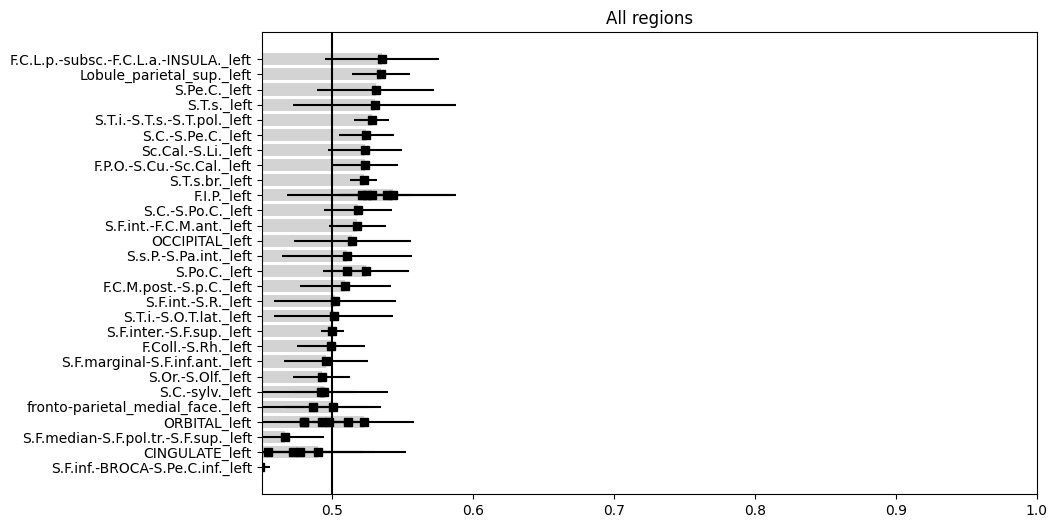

In [26]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

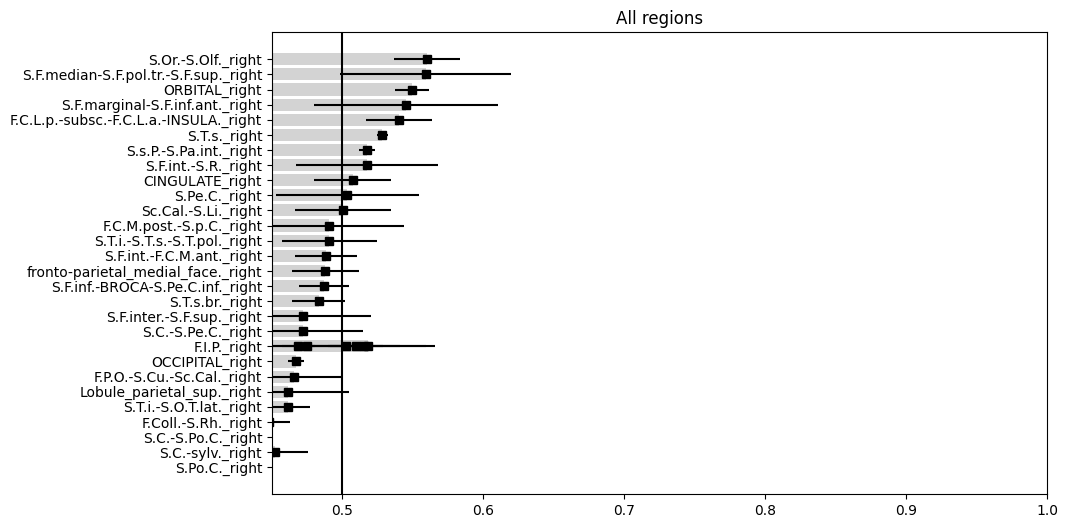

In [27]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [28]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.493766,0.021415,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.491720,0.048020,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.500015,0.008114,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.490661,0.033715,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.447659,0.015407,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,0.472296,0.048251,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,0.530119,0.057980,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,0.490719,0.052889,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,0.549350,0.011876,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [29]:
# df.to_csv(output_filename)